In [1]:
import pandas as pd
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import numpy as np
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l2
import os

In [2]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
stepping	: 3
microcode	: 0xffffffff
cpu MHz		: 2000.230
cache size	: 39424 KB
physical id	: 0
siblings	: 4
core id		: 0
cpu cores	: 2
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch pti ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_dat

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [4]:
dataset_path_train = os.listdir('/kaggle/input/neuroeye-dataset/Eye Disease Image Dataset/Augmented Dataset/Augmented Dataset')
print (dataset_path_train)
print("Types of classes labels found: ", len(dataset_path_train))

['Macular Scar', 'Central Serous Chorioretinopathy [Color Fundus]', 'Pterygium', 'Disc Edema', 'Glaucoma', 'Healthy', 'Retinal Detachment', 'Retinitis Pigmentosa', 'Myopia', 'Diabetic Retinopathy']
Types of classes labels found:  10


In [5]:
from pathlib import Path

base_dir = Path('/kaggle/input/neuroeye-dataset/Eye Disease Image Dataset/Augmented Dataset/Augmented Dataset')

central_serous_chorioretinopathy = base_dir / 'Central Serous Chorioretinopathy [Color Fundus]'
diabetic_retinopathy = base_dir / 'Diabetic Retinopathy'
disc_edema = base_dir / 'Disc Edema'
glaucoma = base_dir / 'Glaucoma'
healthy = base_dir / 'Healthy'
macular_scar = base_dir / 'Macular Scar'
myopia = base_dir / 'Myopia'
pterygium = base_dir / 'Pterygium'
retinal_detachment = base_dir / 'Retinal Detachment'
retinitis_pigmentosa = base_dir / 'Retinitis Pigmentosa'


In [6]:
eye_disease_df = pd.DataFrame()
from tqdm import tqdm

disease_dirs = {
    'central_serous_chorioretinopathy': 0,
    'diabetic_retinopathy': 1,
    'disc_edema': 2,
    'glaucoma': 3,
    'healthy': 4,
    'macular_scar': 5,
    'myopia': 6,
    'pterygium': 7,
    'retinal_detachment': 8,
    'retinitis_pigmentosa': 9
}

for disease_name, label in disease_dirs.items():
    folder = eval(disease_name)  # assumes variables like central_serous_chorioretinopathy = Path(...)
    for imagepath in tqdm(list(folder.iterdir()), desc=disease_name):
        eye_disease_df = eye_disease_df.append({
            'image': str(imagepath),
            'eye_disease_type': label
        }, ignore_index=True)

data_frame = '/kaggle/working/dataset.pickle'
print(f'Saving Dataframe to: {data_frame}')
eye_disease_df.to_pickle(data_frame)


retinitis_pigmentosa: 100%|██████████| 834/834 [00:01<00:00, 581.22it/s]

Saving Dataframe to: /kaggle/working/dataset.pickle


In [7]:
eye_disease_df

,image,eye_disease_type
0,/kaggle/input/neuroeye-dataset/Eye Disease Ima...,0.0
1,/kaggle/input/neuroeye-dataset/Eye Disease Ima...,0.0
2,/kaggle/input/neuroeye-dataset/Eye Disease Ima...,0.0
3,/kaggle/input/neuroeye-dataset/Eye Disease Ima...,0.0
4,/kaggle/input/neuroeye-dataset/Eye Disease Ima...,0.0
...,...,...
16237,/kaggle/input/neuroeye-dataset/Eye Disease Ima...,9.0
16238,/kaggle/input/neuroeye-dataset/Eye Disease Ima...,9.0
16239,/kaggle/input/neuroeye-dataset/Eye Disease Ima...,9.0
16240,/kaggle/input/neuroeye-dataset/Eye Disease Ima...,9.0


In [8]:
eye_disease_df['eye_disease_type'].value_counts()

1.0    3444
3.0    2880
4.0    2676
6.0    2251
5.0    1937
9.0     834
2.0     762
8.0     750
0.0     606
7.0     102
Name: eye_disease_type, dtype: int64

In [9]:
epochs = 3
learning_rate = 0.001 
retrain = False

In [10]:
from torch import Tensor
from torch.nn import (Conv2d, CrossEntropyLoss, Linear, MaxPool2d, ReLU,Sequential, functional, Sigmoid)
import torch
import torch.nn.init as init
import torch.nn as nn

                      
class EyeDiseaseClassification(nn.Module):
    def __init__(self):
        super(EyeDiseaseClassification, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1,stride=1),
            nn.BatchNorm2d(32,track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1,stride=1),
            nn.BatchNorm2d(32,track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1,stride=1),
            nn.BatchNorm2d(64,track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1,stride=1),
            nn.BatchNorm2d(64,track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1,inplace=False),
            nn.Linear(8 * 8 * 64, 1000),
            nn.ReLU(inplace=True),
            nn.Linear(1000, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1,inplace=False),
            nn.Linear(512, 10)
        )
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x

eye_disease_cnn = EyeDiseaseClassification()
print(eye_disease_cnn)

EyeDiseaseClassification(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (

In [11]:
from PIL import Image
import numpy as np
from torch import long, tensor
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandomOrder

class Eye_Class(Dataset):
    def __init__(self, dataFrame):
        self.dataFrame = dataFrame
        self.transformations = Compose([
            Resize((32, 32)),
            ToTensor(),
            Normalize((0.5667, 0.5198, 0.4955),(0.229, 0.224, 0.225))
        ])
    
    def __getitem__(self, key):
        if isinstance(key, slice):
            raise NotImplementedError('Slicing Supported..')
        
        row_loc = self.dataFrame.iloc[key]
        image_rgb = Image.open(row_loc['image']).convert('RGB')
        #image = (image - mean) / std
        #print(image)
        return {
          'image': self.transformations(image_rgb),
          'eye_disease_type': tensor([row_loc['eye_disease_type']], dtype=long),
          'path': row_loc['image']
        }
    
    def __len__(self):
        return len(self.dataFrame.index)

In [12]:
from sklearn.model_selection import KFold
from typing import Dict, List, Union
import pandas as pd
import torch
import torch.nn.init as init
from torch.nn import (Conv2d, CrossEntropyLoss, Linear, MaxPool2d, ReLU,Sequential, MSELoss, L1Loss)
from torch.optim import Adam
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader
import itertools

def prepare_data(eye_disease_df) -> None:
        eye_disease_dataframe = pd.read_pickle(eye_disease_df)
        print(eye_disease_dataframe['eye_disease_type'].value_counts())
        k_fold = KFold(n_splits=10, shuffle=True)
        training_folds = []
        validation_folds = []
        for training_index, validation_index in k_fold.split(eye_disease_dataframe, eye_disease_dataframe['eye_disease_type']):
            training_folds.append(Eye_Class(eye_disease_dataframe.iloc[training_index]))
            validation_folds.append(Eye_Class(eye_disease_dataframe.iloc[validation_index]))
        return [
            training_folds, validation_folds,CrossEntropyLoss()
            ]

def training_dataloader(train_df) -> DataLoader:
    return DataLoader(train_df, batch_size=32, shuffle=True, num_workers=0)
def validation_dataloader(validate_df) -> DataLoader:
    return DataLoader(validate_df, batch_size=32, num_workers=0)   

training_dfs, validation_dfs, cross_entropy_loss = prepare_data('/kaggle/working/dataset.pickle')
training_dfs

1.0    3444
3.0    2880
4.0    2676
6.0    2251
5.0    1937
9.0     834
2.0     762
8.0     750
0.0     606
7.0     102
Name: eye_disease_type, dtype: int64


In [13]:
import warnings
warnings.filterwarnings('ignore')

accuracyvalues = []
training_loss = []

def train_model(train_fold, fold):
    optimizer = Adam(eye_disease_cnn.parameters(), lr=learning_rate)
    
    for epoch in range(epochs):
        total, correct = 0, 0
        loss_train = 0.0
        
        for j, data in enumerate(training_dataloader(train_fold), 0):
            inputs = data['image']
            labels = data['eye_disease_type'].flatten()

            outputs = eye_disease_cnn(inputs)
            loss = cross_entropy_loss(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # accumulate training accuracy & loss
            total += labels.size(0)
            _, predicted_values = torch.max(outputs.data, 1)
            correct += (predicted_values == labels).sum().item()
            loss_train += loss.item()

        accuracy = (correct / total) * 100
        print(f"Fold {fold + 1} | Epoch {epoch + 1} => Loss: {loss_train:.4f}, Accuracy: {accuracy:.2f}%")
        
        accuracyvalues.append(accuracy)
        training_loss.append(loss_train)


In [14]:
from numpy import vstack
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

def evaluate_model(validate_fold):
    prediction_values, actual_values = torch.tensor([]), torch.tensor([])
    for i, data in enumerate(validation_dataloader(validate_fold)):
        inputs, targets = data['image'], data['eye_disease_type']
        targets = targets.flatten()
        output = eye_disease_cnn(inputs)
        output = torch.argmax(output,axis=1)
        prediction_values = torch.cat((prediction_values, output.flatten()), dim=0)
        actual_values = torch.cat((actual_values, targets), dim=0)

    return (confusion_matrix(actual_values.numpy(), prediction_values.numpy()),accuracy_score(actual_values, prediction_values),*precision_recall_fscore_support(actual_values.numpy(), prediction_values.numpy(),average='macro'))

In [15]:
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import pandas as pd

fold_outputs = []
fold_con_matrix = np.zeros((10, 10))  # updated to 10x10 for 10 diseases

classes = [
    'Central Serous Chorioretinopathy',
    'Diabetic Retinopathy',
    'Disc Edema',
    'Glaucoma',
    'Healthy',
    'Macular Scar',
    'Myopia',
    'Pterygium',
    'Retinal Detachment',
    'Retinitis Pigmentosa'
]

for fold in range(len(training_dfs)):
    print("Running Fold : " + str(fold + 1))
    print(training_dfs[fold], fold)
    train_model(training_dfs[fold], fold)
    fold_result = evaluate_model(validation_dfs[fold])
    # fold_result = (confusion_matrix, accuracy, precision, recall, f1-score)
    fold_outputs.append(fold_result[1:-1])
    fold_con_matrix = np.add(fold_con_matrix, fold_result[0])
    if fold != len(training_dfs) - 1:
        eye_disease_cnn = EyeDiseaseClassification()

report = pd.DataFrame(fold_outputs, columns=['accuracy', 'precision', 'recall', 'f1-score'])
print()
print("Classification Report")
print(report.mean())
print()


Running Fold : 1
<__main__.Eye_Class object at 0x7ac441c6d590> 0
Fold 1 | Epoch 1 => Loss: 751.8908, Accuracy: 40.41%
Fold 1 | Epoch 2 => Loss: 603.8154, Accuracy: 51.93%
Fold 1 | Epoch 3 => Loss: 511.4366, Accuracy: 59.29%
Running Fold : 2
<__main__.Eye_Class object at 0x7ac441c75590> 1
Fold 2 | Epoch 1 => Loss: 746.8150, Accuracy: 41.44%
Fold 2 | Epoch 2 => Loss: 576.5808, Accuracy: 54.38%
Fold 2 | Epoch 3 => Loss: 493.2534, Accuracy: 60.46%
Running Fold : 3
<__main__.Eye_Class object at 0x7ac441c75910> 2
Fold 3 | Epoch 1 => Loss: 733.6443, Accuracy: 41.84%
Fold 3 | Epoch 2 => Loss: 573.0957, Accuracy: 54.92%
Fold 3 | Epoch 3 => Loss: 489.3540, Accuracy: 61.03%
Running Fold : 4
<__main__.Eye_Class object at 0x7ac441c75f90> 3
Fold 4 | Epoch 1 => Loss: 737.7915, Accuracy: 42.12%
Fold 4 | Epoch 2 => Loss: 567.0081, Accuracy: 55.06%
Fold 4 | Epoch 3 => Loss: 480.3723, Accuracy: 61.68%
Running Fold : 5
<__main__.Eye_Class object at 0x7ac4419413d0> 4
Fold 5 | Epoch 1 => Loss: 733.1687, Acc

In [16]:
torch.save(eye_disease_cnn,'eye_disease_classification.pkl')

In [17]:
import os
import torch
if os.path.exists('eye_disease_classification.pkl'): 
    print("Yes")
else:
    print("No model saved")

Yes


To save the Model -> Which helps in skipping the Training Part

In [18]:
import os
import torch
if os.path.exists('eye_disease_classification.pkl'): 
    modelTrained = torch.load('eye_disease_classification.pkl')
else:
    print("No model saved")

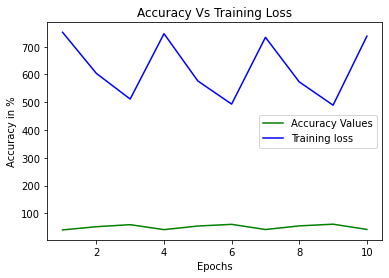

In [19]:
epochvalues = range(1,11)
acc_val = accuracyvalues[:10]
train_loss = training_loss[:10]
plt.plot(epochvalues,acc_val,'g',label='Accuracy Values')
plt.plot(epochvalues,train_loss,'b',label='Training loss')
plt.title('Accuracy Vs Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy in %')
plt.legend()
plt.show()

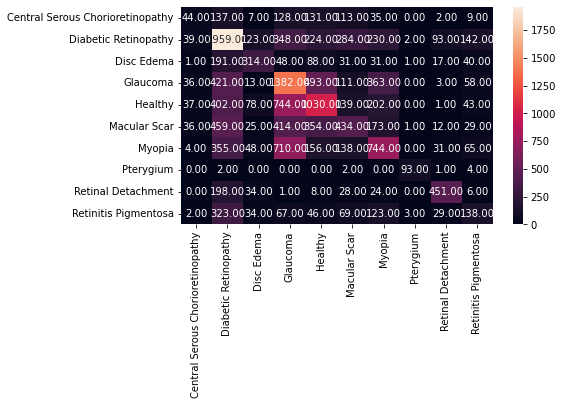

In [20]:
#Plotting Confusion Matrix
df_cm = pd.DataFrame(fold_con_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (7,4))
sn.heatmap(df_cm, annot=True,fmt='.2f')
plt.savefig('output.png')

In [21]:
# import random
# test_dataset_path = Path('/kaggle/input/eye-diseases-classification/dataset')
# test_dataset_list_path = os.listdir(test_dataset_path)
# test_randomdisease_path = random.choice(test_dataset_list_path)
# test_random = test_dataset_path/test_randomdisease_path
# test_random

In [22]:
# from tqdm import tqdm
# import matplotlib.pyplot as plt
# import random

# class_mapping_values = {0: "cataract", 1: "diabetic_retinopathy", 2: "glaucoma", 3: "normal"}

# def prepare_eyedisease_prediction_df():
#     test_dataset_path = Path('/kaggle/input/eye-diseases-classification/dataset')
#     test_dataset_list_path = os.listdir(test_dataset_path)
#     test_randomdisease_path = random.choice(test_dataset_list_path)
#     test_random = test_dataset_path/test_randomdisease_path
#     test_dataframe = pd.DataFrame()

#     #Appending values to the images - Key value pair
#     for imagePath in tqdm(list(test_random.iterdir()), desc='cataract'):
#         test_dataframe = test_dataframe.append({
#             'image': str(imagePath),
#             'eye_disease_type': 0
#         }, ignore_index=True)

#     for imagePath in tqdm(list(test_random.iterdir()), desc='diabetic_retinopathy'):
#         test_dataframe = test_dataframe.append({
#             'image': str(imagePath),
#             'eye_disease_type': 1
#         }, ignore_index=True)

#     for imagePath in tqdm(list(test_random.iterdir()), desc='glaucoma'):
#         test_dataframe = test_dataframe.append({
#             'image': str(imagePath),
#             'eye_disease_type': 2
#         }, ignore_index=True)
        
#     for imagePath in tqdm(list(test_random.iterdir()), desc='surgical'):
#         test_dataframe = test_dataframe.append({
#             'image': str(imagePath),
#             'eye_disease_type': 3
#         }, ignore_index=True)
        
    
#     #Counts the number of images in each category
#     print("Length of the Test_Dataframe",len(test_dataframe.value_counts()))
#     return Eye_Class(test_dataframe)

In [23]:
# def test_eyedisease_predict():
#     test_dataframe = prepare_eyedisease_prediction_df()
#     random_sampler = torch.utils.data.RandomSampler(test_dataframe, num_samples=32, replacement=True)
#     test_data = iter(DataLoader(test_dataframe, batch_size=32, num_workers=0, sampler=random_sampler)).next()
#     inputs,targets = test_data['image'], test_data['eye_disease_type']
#     test_output = modelTrained(inputs)
#     test_output = torch.argmax(test_output,axis=1)
#     rand_val = random.choice(list(range(0,32)))
#     print(test_data['path'][rand_val])
#     img = Image.open(test_data['path'][rand_val])
#     plt.imshow(np.asarray(img))
#     print("Predicted:",class_mapping_values[test_output[rand_val].tolist()])

# test_eyedisease_predict()

In [24]:
'''def create_mask_for_image(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_hsv = np.array([0,0,250])
    upper_hsv = np.array([250,255,255])
    
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask'''

'def create_mask_for_image(image):\n    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)\n\n    lower_hsv = np.array([0,0,250])\n    upper_hsv = np.array([250,255,255])\n    \n    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)\n    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))\n    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)\n    return mask'

In [25]:
'''from keras.preprocessing import image
data_kaggle = '/kaggle/input/eye-diseases-classification/dataset/'
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_kaggle, filepath), target_size=size)
    #convert image to array
    img = image.img_to_array(img)
    return img
img = read_img(eye_disease_df['image'][40],(255,255))
img_preprocess = create_mask_for_image(img)
img_preprocess
fig, ax = plt.subplots(1, 2, figsize=(5, 5));
plt.suptitle('RESULT', x=0.5, y=0.8)
ax[0].set_title('ORIGINAL', fontsize=12)
ax[1].set_title('MASK', fontsize=12)
ax[0].imshow(img/255);
ax[1].imshow(img_preprocess);
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp
img = read_img(eye_disease_df['image'][40],(255,255))
#sharpen the image
image_sharpen = sharpen_image(img)
fig, ax = plt.subplots(1, 2, figsize=(5, 5));
plt.suptitle('RESULT', x=0.5, y=0.8)
plt.tight_layout(1)
ax[0].set_title('ORIGINAL', fontsize=12)
ax[1].set_title('SHARPEN', fontsize=12)
ax[0].imshow(img/255);
ax[1].imshow(image_sharpen);
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

img = Image.open('/kaggle/input/eye-diseases-classification/dataset/cataract/0_left.jpg')
img_aug = transform(img)
img_aug'''

"from keras.preprocessing import image\ndata_kaggle = '/kaggle/input/eye-diseases-classification/dataset/'\ndef read_img(filepath, size):\n    img = image.load_img(os.path.join(data_kaggle, filepath), target_size=size)\n    #convert image to array\n    img = image.img_to_array(img)\n    return img\nimg = read_img(eye_disease_df['image'][40],(255,255))\nimg_preprocess = create_mask_for_image(img)\nimg_preprocess\nfig, ax = plt.subplots(1, 2, figsize=(5, 5));\nplt.suptitle('RESULT', x=0.5, y=0.8)\nax[0].set_title('ORIGINAL', fontsize=12)\nax[1].set_title('MASK', fontsize=12)\nax[0].imshow(img/255);\nax[1].imshow(img_preprocess);\ndef sharpen_image(image):\n    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)\n    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)\n    return image_sharp\nimg = read_img(eye_disease_df['image'][40],(255,255))\n#sharpen the image\nimage_sharpen = sharpen_image(img)\nfig, ax = plt.subplots(1, 2, figsize=(5, 5));\nplt.suptitle('RESULT', x=0.5